##Whole Slide Imaging DICOM De-identification

In this notebook, we will explore how to handle the de-identification of Whole Slide Imaging (WSI) files, specifically focusing on DICOM format.

We will cover:

* Extract tiles from the WSI DICOM file

* De-identify individual tile images

* Deidentify metadata

* Update the original WSI DICOM by replacing the sensitive tiles

Let's jump right in!

###Colab Setup

In [ ]:
secret = ""
license = ""
version = secret.split("-")[0]
spark_ocr_jar_path = "../../target/scala-2.12"

**Note:** Restart Environment

###Initialization of spark session

In [ ]:
import os
from sparkocr import start

spark = start(jar_path="./",
              nlp_secret="6.0.2-xyz",
              nlp_internal=True,
              nlp_jsl=True,
              nlp_version="6.0.2",
              use_gpu=False)

spark

## Import Spark OCR transformers and Spark NLP annotators

In [ ]:
import os
import sys

from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp_jsl
from sparknlp_jsl.annotator import *

import sparkocr
from sparkocr.transformers import *
from sparkocr.utils import *
from sparkocr.enums import *

from pyspark.ml import PipelineModel, Pipeline

print(f"Spark NLP version: {sparknlp.version()}")
print(f"Spark NLP internal version: {sparknlp_jsl.version()}")
print(f"Spark OCR version: {sparkocr.version()}")

Spark NLP version: 6.0.2
Spark NLP internal version: 6.0.2
Spark OCR version: 6.0.1rc1


### Define Pipeline to convert Dicom to image and for text detection

In [ ]:
from pyspark.ml import PipelineModel, Pipeline

dicom_to_image = DicomToImageV3() \
    .setInputCols(["content"]) \
    .setOutputCol("image_raw") \
    .setKeepInput(True)

text_detector = ImageTextDetector.pretrained("image_text_detector_mem_opt", "en", "clinical/ocr") \
    .setInputCol("image_raw") \
    .setOutputCol("text_regions") \
    .setScoreThreshold(0.7) \
    .setLinkThreshold(0.5) \
    .setWithRefiner(True) \
    .setTextThreshold(0.4) \
    .setSizeThreshold(-1) \
    .setUseGPU(False) \
    .setWidth(0)

new_stages = [
    dicom_to_image,
    text_detector
]

pipeline = PipelineModel(stages=new_stages)

image_text_detector_mem_opt download started this may take some time.
Approximate size to download 77.5 MB


### Read dicom objects as binary file and display metadata

/usr/local/lib/python3.11/dist-packages/pydicom/pixels/decoders/base.py:302: UserWarning: The (0028,0004) 'Photometric Interpretation' value is 'RGB' however the encoded image's codestream contains a JFIF APP marker which indicates it should be 'YBR_FULL_422'
  warn_and_log(


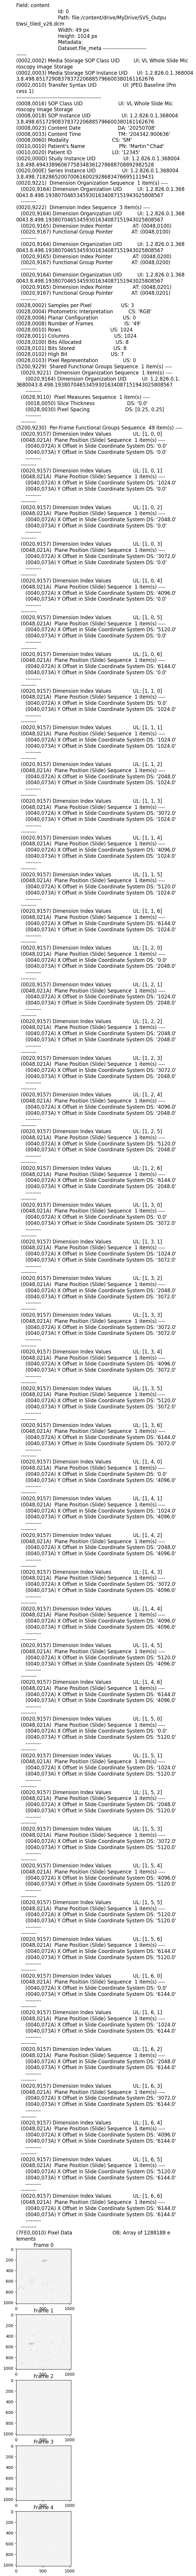

In [ ]:
from sparkocr.utils import display_dicom

dicom_path = './data/wsi/wsi_tiled.dcm'
dicom_df = spark.read.format("binaryFile").load(dicom_path).limit(1)

display_dicom(dicom_df)

###Run pipeline

In [ ]:
result = pipeline.transform(dicom_df).cache()

/usr/local/lib/python3.11/dist-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


**NOTE:** You can filter the tiles with detected text and use it as input for deid pipeline, other tiles won't be fed into the pipeline, so that we don't waste resources analyzing them.

#### Inspect target images
Let's look into some of the images containing text,

In [ ]:
from pyspark.sql.functions import size
result = result.filter(size(result["text_regions"]) > 0).cache()

### PHI removal per-se

In [ ]:
from sparkocr.pretrained import PretrainedPipeline
deid_pipeline = PretrainedPipeline("image_deid_multi_model_context_pipeline_cpu", "en", "clinical/ocr")

image_deid_multi_model_context_pipeline_cpu download started this may take some time.
Approx size to download 5.3 GB
[OK!]


###Run pipeline

In [ ]:
stages = deid_pipeline.model.stages
new_pipe = PipelineModel(stages)

In [ ]:
result_deid = new_pipe.transform(result)
deid_info = result_deid.select("path", "coordinates", "content").distinct()

#### [optional] Cache regions using parquet
We can cache the regions in disk, to avoid potential re-computation and to be able to recover in case of failure.

In [ ]:
deid_info.repartition(10).write.format("parquet").mode("overwrite").save("./cached_regions.parquet")

In [ ]:
deid_info = spark.read.parquet("./cached_regions.parquet").repartition(10)

#### Display deid tile
Let's take a look at the result of this process


    Image #0:
    Origin: file:/content/drive/MyDrive/SVS_Output/wsi_tiled_v26.dcm
    Resolution: 0 dpi
    Width: 1024 px
    Height: 1024 px
    Mode: 10
    Number of channels: 1


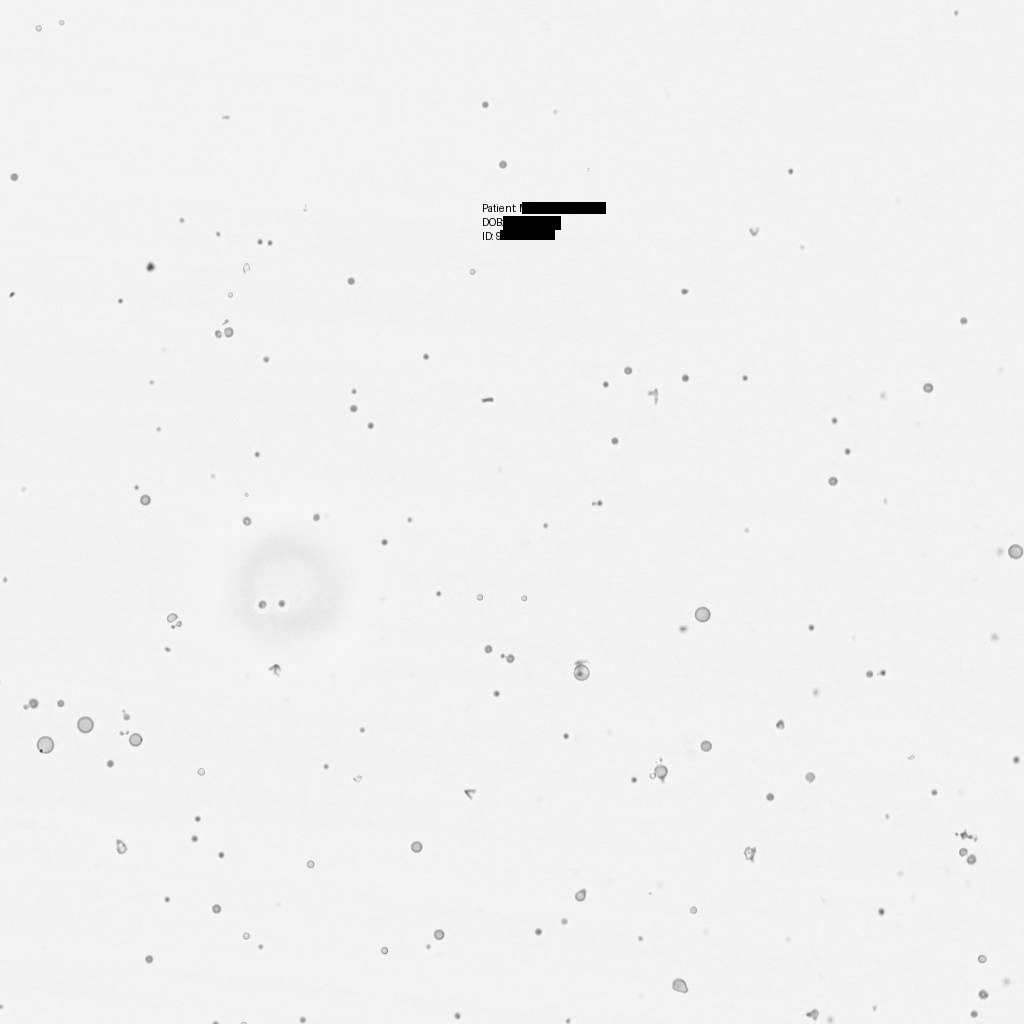


    Image #1:
    Origin: file:/content/drive/MyDrive/SVS_Output/wsi_tiled_v26.dcm
    Resolution: 0 dpi
    Width: 1024 px
    Height: 1024 px
    Mode: 10
    Number of channels: 1


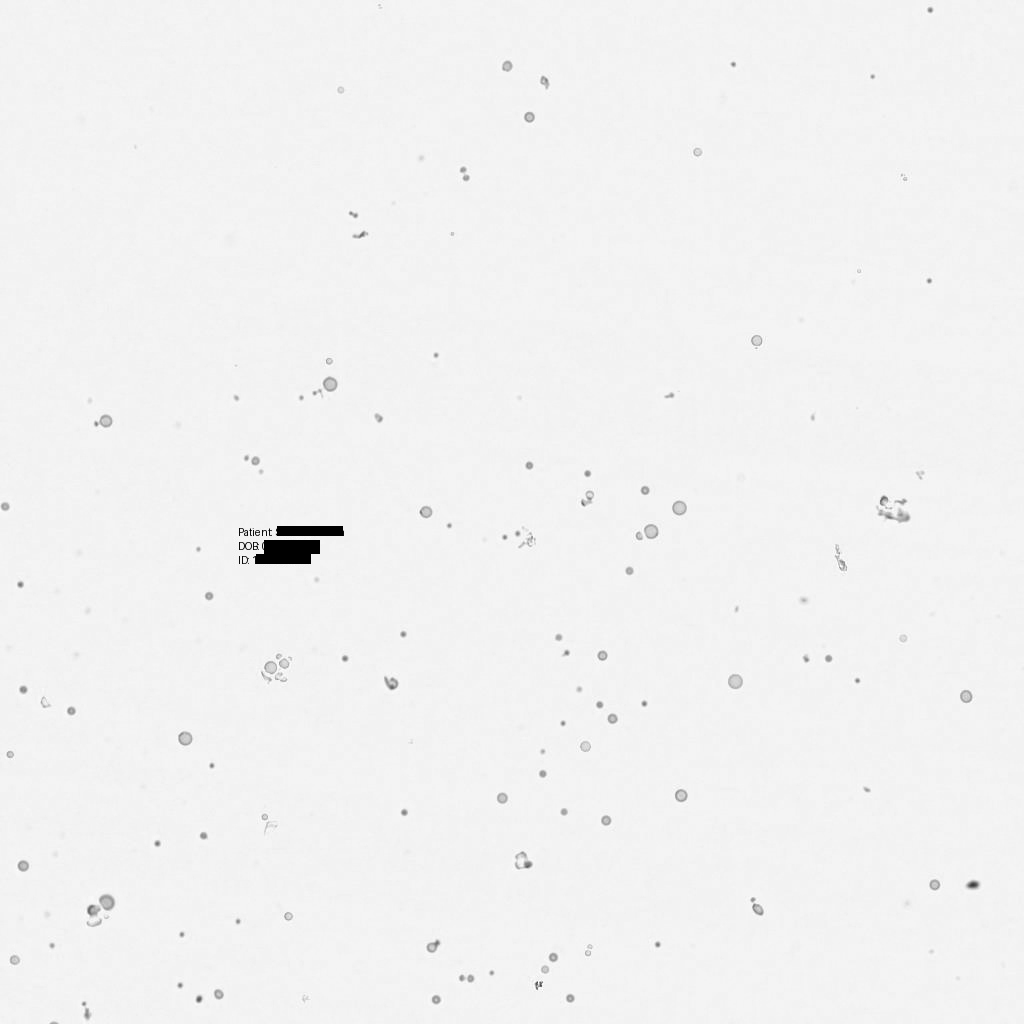

In [ ]:
from sparkocr.utils import display_images
display_images(result_deid, "image_with_regions")

### Define Pipeline to draw PHI regions and clean metadata in the Dicom file

In [ ]:
# Draw filled rectangle for hide sensitive data
draw_regions = DicomDrawRegions() \
    .setInputCol("content") \
    .setInputRegionsCol("coordinates") \
    .setOutputCol("dicom") \
    .setAggCols(["path", "content"]) \
    .setKeepInput(True)

dicom_deidentifier = DicomMetadataDeidentifier() \
    .setInputCols(["dicom"]) \
    .setOutputCol("dicom_cleaned")\
    .setKeepInput(True)

new_stages = [
    draw_regions,
    dicom_deidentifier
]

dicom_pipeline = PipelineModel(stages=new_stages)

###Run pipeline

In [ ]:
stages = dicom_pipeline.stages
new_pipe = PipelineModel(stages)

In [ ]:
result_clean = new_pipe.transform(result_deid).cache()

/usr/local/lib/python3.11/dist-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


###Inspect Intermmediate Stages

In [ ]:
display_dicom(result_clean, "content, dicom_cleaned")

###Write results back to disk

In [ ]:
# NBVAL_SKIP
output_path = "./../data/dicom/deidentified/"
from pyspark.sql.functions import *

def get_name(path, keep_subfolder_level=0):
    path = path.split("/")
    path[-1] = path[-1].split('.')[0]
    return "/".join(path[-keep_subfolder_level-1:])

result_clean.withColumn("fileName", udf(get_name, StringType())(col("path"))) \
    .write \
    .format("binaryFormat") \
    .option("type", "dicom") \
    .option("field", "dicom_cleaned") \
    .option("prefix", "ocr_") \
    .option("nameField", "fileName") \
    .mode("overwrite") \
    .save(output_path)

In [ ]:
# NBVAL_SKIP
dicom_gen_df = spark.read.format("binaryFile").load("./../data/dicom/deidentified/*.dcm")
display_dicom(dicom_gen_df)

In [ ]:
%%bash
rm -r -f ./../data/dicom/deidentified